# 1) Install dependencies and import libraries

In [3]:
!pip install matplotlib numpy scikit-learn scipy pandas scikeras

In [7]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold, train_test_split
from scikeras.wrappers import KerasRegressor

# 2) Import and preprocess data 

In [11]:
directory = 'D:\DSUA\data'
original_curves = []
noised_curves = []

original_files = np.array([filename for filename in os.listdir(directory) if filename.endswith('_0.csv')])

for original_filename in original_files:
    original_curve = pd.read_csv(os.path.join(directory, original_filename))

    original_curves.append(np.array(original_curve).flatten())
    
    original_id = original_filename.split('_')[1:3]
    original_id ='_'.join(original_id)
    
    for i in range(1, 10):
        noised_filename = f'cor_{original_id}_{i}.csv'

        if noised_filename in os.listdir(directory):
            noised_curve = pd.read_csv(os.path.join(directory, noised_filename))
            noised_curves.append(np.array(noised_curve).flatten())

In [12]:
original_curves = np.repeat(np.vstack(original_curves), 9, axis=0)
noised_curves = np.vstack(noised_curves)

In [13]:
def standardize_data(data):
    return np.array([(row - np.mean(row)) / np.std(row) if np.std(row) != 0 else row for row in data])

In [14]:
original_curves = standardize_data(original_curves)
noised_curves = standardize_data(noised_curves)

# EDA

In [8]:
def plot_curve(df_orig, df_noise):
    plt.plot(df_orig, label='Original curve', color='blue')
    plt.plot(df_noise, label='Noised curve', color='red')  
    
    plt.xlabel('Index')
    plt.ylabel('Value')  
    
    plt.title('Comparison') 
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [15]:
#Create an empty DataFrame with columns
df = pd.DataFrame(columns=['Noise Curve', 'Noise Level', 'Original Curve'])

for i, (noised_curve, original_curve) in enumerate(zip(noised_curves, original_curves)):
    row = [noised_curve, (i % 9) + 1, original_curve] 
    
    # Append the new row to the DataFrame
    df.loc[len(df)] = row

In [221]:
df_orig = pd.read_csv("D:\DSUA\data\cor_0_2_0.csv")
# df_orig

In [222]:
df_noise = pd.read_csv("D:\DSUA\data\cor_0_2_6.csv")
# df_noise

In [ ]:
# df_orig.describe()

In [10]:
# df_noise.describe()

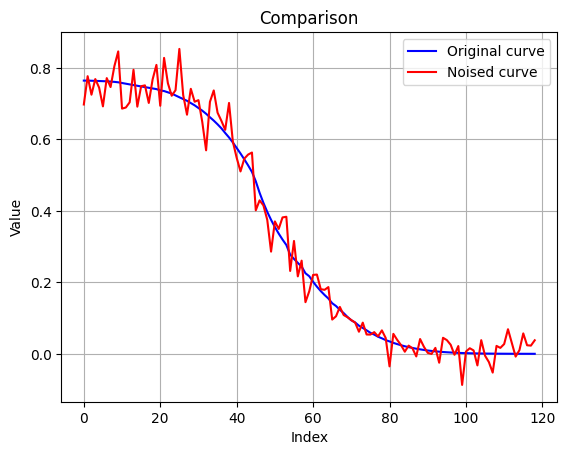

In [223]:
plot_curve(df_orig, df_noise)

# 3) Create model

In [17]:
sequence_length = 119
num_epochs = 30
batch_size = 32

In [18]:
features = noised_curves  
labels = original_curves

In [ ]:
#High snr score, but poor fold loss (bad gerenarilzation)

# def create_lstm_model(dropout_rate=0.2):
#     model = Sequential([
#         keras.layers.LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 1)),
#         keras.layers.Dropout(dropout_rate),
#         keras.layers.LSTM(units=32),
#         keras.layers.Dense(sequence_length)
#     ])

#     opt = keras.optimizers.Adagrad(1e-1)
#     model.compile(loss='mse', optimizer=opt)
#     return model

In [188]:
def create_lstm_model(dropout_rate=0.2):
    model = Sequential([
        keras.layers.LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 1)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.LSTM(units=32),
        keras.layers.Dropout(dropout_rate / 2),
        keras.layers.Dense(sequence_length)
    ])

    opt = keras.optimizers.Adagrad(1e-2)
    model.compile(loss='mse', optimizer=opt)
    return model

K-Fold cross-validation is a good validation technique because it reduces overfitting, ensures better utilization of data and makes model more robust overall

In [189]:
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

model = KerasRegressor(model=create_lstm_model, epochs=num_epochs, batch_size=batch_size)

In [190]:
# Perform KFold cross-validation with validation on each fold
cvscores = []
for train, test in cv.split(X_train):
  
  # Train on the training fold
  model.fit(X_train[train], y_train[train])  

  # Evaluate on the validation set
  loss = model.score(X_val, y_val) 
    
  cvscores.append(loss)
  print(f"Fold loss: {loss}")

# Print average cross-validation score
print(f"Average CV loss: {np.mean(cvscores)}")

Epoch 1/30
75/75 [==============================] - 5s 36ms/step - loss: 0.7360
Epoch 2/30
75/75 [==============================] - 3s 39ms/step - loss: 0.6065
Epoch 3/30
75/75 [==============================] - 3s 36ms/step - loss: 0.4538
Epoch 4/30
75/75 [==============================] - 3s 34ms/step - loss: 0.3369
Epoch 5/30
75/75 [==============================] - 3s 34ms/step - loss: 0.2441
Epoch 6/30
75/75 [==============================] - 3s 34ms/step - loss: 0.1773
Epoch 7/30
75/75 [==============================] - 3s 34ms/step - loss: 0.1461
Epoch 8/30
75/75 [==============================] - 3s 39ms/step - loss: 0.1342
Epoch 9/30
75/75 [==============================] - 3s 39ms/step - loss: 0.1293
Epoch 10/30
75/75 [==============================] - 3s 36ms/step - loss: 0.1265
Epoch 11/30
75/75 [==============================] - 3s 34ms/step - loss: 0.1249
Epoch 12/30
75/75 [==============================] - 3s 34ms/step - loss: 0.1240
Epoch 13/30
75/75 [==================

# 4) Evaluate model

SNR (Signal-to-Noise Ratio) is a good evaluation metric for denoising curves because it provides a quantitative measure of the quality of the denoised signal relative to the noise present in the original signal.

In [200]:
def calculate_snr(clean_curves, denoised_curves):
    
    # Calculate signal power
    signal_power = tf.reduce_sum(tf.square(clean_curves))

    # Calculate noise power
    noise = clean_curves - denoised_curves
    noise_power = tf.reduce_sum(tf.square(noise))

    # Calculate SNR
    snr = 10 * tf.math.log(signal_power / noise_power) / tf.math.log(10.0)
    return snr

In [201]:
original_curves = tf.cast(original_curves, dtype=tf.float32)
denoised_curves = model.predict(noised_curves)
denoised_curves = tf.cast(denoised_curves, dtype=tf.float32)

snr = calculate_snr(original_curves, denoised_curves)
snr

141/141 [==============================] - 2s 14ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=8.931012>

Grid Search Cross-Validation was used to determine best parameters for the model

In [198]:
# def create_lstm_model(sequence_length=119, learning_rate=0.01, dropout_rate=0.2):
#     model = Sequential([
#         keras.layers.LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 1)),
#         keras.layers.Dropout(dropout_rate),
#         keras.layers.LSTM(units=32),
#         keras.layers.Dense(sequence_length)
#     ])
#     model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
#     return model


# def snr_scorer(y_true, y_pred):
    
#     snr_values = calculate_snr(y_true, y_pred)
#     return np.mean(snr_values)


# lstm_regressor = KerasRegressor(model=create_lstm_model, verbose=0)


# param_grid = {
#     'optimizer': ["rmsprop", "adadelta", "adagrad", "SGD"],
#     'loss': ["mse", "mae"],
#     'batch_size': [16, 32, 64],
#     'epochs': [30, 50, 70]
# }


# grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=3, scoring=make_scorer(snr_scorer))
# grid_search.fit(X_train, y_train)  


# print("Best parameters found: ", grid_search.best_params_)
# print("Best SNR score found: ", grid_search.best_score_)

In [239]:
def save_denoised_curves(path, original_curves, deniosed_curves):
    df = pd.DataFrame(columns=['Denoised Curve', 'Original Curve'])

    for denoised_curve, original_curve in zip(denoised_curves, original_curves):
        row = [noised_curve, original_curve] 
    
        df.loc[len(df)] = row
    
    path = os.path.join(path, "denoised_curves.csv")
    df.to_csv(path)

In [240]:
save_denoised_curves("D:\DSUA", np.array(original_curves), np.array(denoised_curves))

1/1 [==============================] - 0s 29ms/step


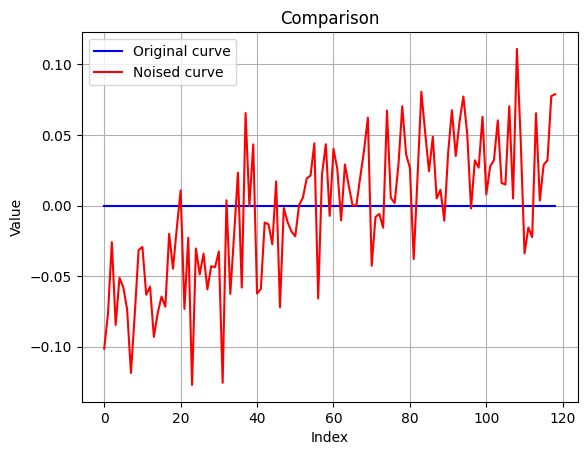

In [229]:
#Plot the original and denoised curves

def show_curve(orig_curve, noise_curve):
    plt.plot(orig_curve, label='Original curve', color='blue')
    plt.plot(noise_curve, label='Noised curve', color='red')  
    
    plt.xlabel('Index')
    plt.ylabel('Value')  
    
    plt.title('Comparison') 
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage
example = np.array(original_curves[0])
example = example.reshape(1, -1)
d_example = model.predict(example)

plot_curve(example.flatten(), d_example.flatten())